# Task Analysis

In questo Notebook annoterò il processo di studio della fattibilità e della progettazione del sistema.

## Primi Obiettivi
Per definire la fattibilità del progetto ho bisogno, prima di tutto, di:
- Definire la disponibilità di dati
- Definire la struttura del sistema e le tecnologie da utilizzare

## Definizione dell'Idea Iniziale
L'idea iniziale è quella di creare una soluzione che permetta di riconoscere posizioni di scacchi da immagini.

Una prima possibile implementazione potrebbe utilizzare tre moduli principali:
- Un modulo di riconoscimento delle posizioni dei pezzi nell'immagine
- Un modulo di riconoscimento della posizione della scacchiera nell'immagine
- Un modulo che metta insieme le informazioni precedenti per ottenere una posizione di scacchi

Per quanto riguarda il modulo di riconoscimento delle posizioni dei pezzi, si potrebbe utilizzare un modello di object detection, ad esempio YOLO, per riconoscere i pezzi. Per questo modulo ne studierò la fattibilità più avanti.

Per quanto riguarda il terzo modulo, grazie alla libreria python-chess, è possibile ottenere una rappresentazione della posizione di scacchi in formato FEN (Forsyth-Edwards Notation). Questo modulo potrebbe essere implementato in modo molto semplice.

I dubbi principali li ho sul secondo modulo:
Quanto è complicato riconoscere la posizione della scacchiera nell'immagine? Ho già giocato un po' con OpenCV usando tecniche di riconoscimento di pattern, ma non sono riuscito a trovare una soluzione che funzionasse bene.

Il problema principale è che il modello deve riconoscere il pattern della scacchiera in condizioni diverse di angolazione e illuminazione. Questo potrebbe essere un problema molto complesso.

Sto pensando all'utilizzo di un modello pre-addestrato per il riconoscimento di keypoints, nel caso proverò a utilizzare modelli più complessi con tecniche di fine-tuning.

Provo un modello pre-trainato consigliato da ChatGPT:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


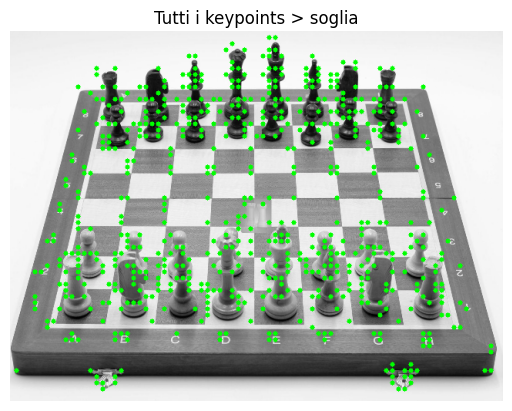

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Hull has 14 points. Approx has 4 vertices.


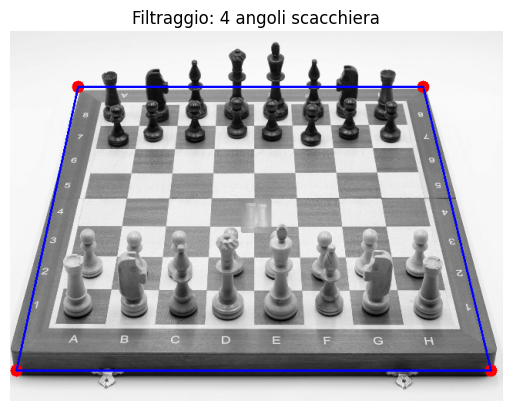

In [1]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request

###############################################################################
# 1) Scarica il file dei pesi "superpoint_v1.pth" (se serve)
###############################################################################
model_path = "superpoint_v1.pth"
if not os.path.exists(model_path):
    print("Scaricando il modello SuperPoint...")
    url = "https://github.com/MagicLeapResearch/SuperPointPretrainedNetwork/raw/master/superpoint_v1.pth"
    urllib.request.urlretrieve(url, model_path)
    print("Modello scaricato con successo!")

###############################################################################
# 2) Definisci la rete SuperPoint compatibile con i pesi (65 canali)
###############################################################################
class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Strati convoluzionali di base
        self.conv1a = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        # Strati per keypoints
        self.convPa = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(256, 65, kernel_size=1, stride=1, padding=0)

        # Strati per descrittori (non usati qui)
        self.convDa = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Passaggi base
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))

        # Output keypoints (65 canali)
        cPa = self.relu(self.convPa(x))
        keypoints = self.convPb(cPa)

        return keypoints

###############################################################################
# 3) Carica la rete e i pesi
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SuperPointNet().to(device)

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.eval()

###############################################################################
# 4) Funzioni di utilità
###############################################################################
def preprocess_image(img_path):
    """Carica l'immagine, ridimensiona a 640x480, converte in scala di grigi e in Tensor."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (640, 480))
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)
    return img_tensor, img

def get_keypoints(model, img_tensor):
    """Ottiene i canali [1,65,H//8,W//8] e riduce a [65,H//8,W//8]."""
    with torch.no_grad():
        out = model(img_tensor)  # -> [1,65,h,w]
    return out.squeeze(0).cpu().numpy()  # -> [65,h,w]

def draw_all_keypoints(img_gray, keypoint_map, threshold=0.5):
    """
    Visualizza TUTTI i punti che superano threshold:
    1) Ignoriamo l'ultimo canale dustbin => keypoint_map[:64]
    2) max su asse canali => [h, w]
    """
    kpts_64 = keypoint_map[:64]       # [64,h,w]
    kpts_2d = kpts_64.max(axis=0)     # [h,w]

    img_color = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    h, w = kpts_2d.shape

    for y in range(h):
        for x in range(w):
            if kpts_2d[y, x] > threshold:
                px, py = x*8, y*8
                cv2.circle(img_color, (px, py), 3, (0, 255, 0), -1)

    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.title("Tutti i keypoints > soglia")
    plt.axis("off")
    plt.show()

def filter_and_draw_corners(img_gray, keypoint_map, threshold=0.5):
    """
    Esempio di FILTRAGGIO degli angoli della scacchiera:
    1) Creiamo la mappa 2D da 64 canali (max).
    2) Estraiamo le coordinate (x,y) dei punti validi.
    3) Calcoliamo hull convesso -> poligono con approx = 4 vertici.
    4) Disegniamo i vertici finali.
    """
    # 1) Mappa 2D di confidenza
    kpts_64 = keypoint_map[:64]       # [64,h,w]
    kpts_2d = kpts_64.max(axis=0)     # [h,w]

    # 2) Estraiamo coordinate
    pts = []
    h, w = kpts_2d.shape
    for y in range(h):
        for x in range(w):
            if kpts_2d[y, x] > threshold:
                pts.append((x*8, y*8))  # back in full resolution

    pts = np.array(pts, dtype=np.int32)
    img_color = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

    if len(pts) < 4:
        # Nessun poligono da estrarre
        print("Pochi keypoints, non posso trovare un quadrilatero.")
        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
        return

    # 3) Convex Hull
    hull = cv2.convexHull(pts)  # array Nx1x2

    # Approximiamo con 4 vertici (sperando che la scacchiera appaia come quadrilatero)
    epsilon = 0.05 * cv2.arcLength(hull, True)  # 5% del perimetro
    approx = cv2.approxPolyDP(hull, epsilon, True)

    # Se l'approx non ha 4 vertici, potremmo forzare di più, o gestire altre approssimazioni
    print(f"Hull has {len(hull)} points. Approx has {len(approx)} vertices.")
    if len(approx) == 4:
        # 4) Disegniamo i vertici finali
        for i in range(4):
            px, py = approx[i][0]  # approx[i] è un array [[x,y]]
            cv2.circle(img_color, (px, py), 8, (0, 0, 255), -1)  # grande cerchio rosso
        cv2.polylines(img_color, [approx], True, (255, 0, 0), 2)
    else:
        print("Non siamo riusciti a trovare esattamente 4 angoli. Ecco l'approx poligonale attuale.")

    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.title("Filtraggio: 4 angoli scacchiera")
    plt.axis("off")
    plt.show()

###############################################################################
# 5) Demo con un'immagine di scacchiera
###############################################################################
img_path = "scacchiera.jpg"  # Cambia con il tuo file
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Non ho trovato {img_path} nella cartella corrente!")

img_tensor, img_gray = preprocess_image(img_path)
kmap = get_keypoints(model, img_tensor)  # -> [65,h,w]

# A) Disegniamo TUTTI i keypoints
draw_all_keypoints(img_gray, kmap, threshold=0.5)

# B) Filtraggio e disegno dei soli 4 vertici del contorno
filter_and_draw_corners(img_gray, kmap, threshold=0.5)


Non riesco a trovare abbastanza linee orizz/vert.


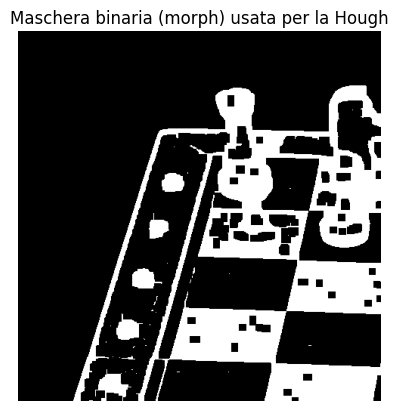

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_corners(corners):
    """Riordina i 4 angoli in [top-left, top-right, bottom-right, bottom-left]."""
    corners = np.squeeze(corners)
    corners_sorted = sorted(corners, key=lambda x: (x[1], x[0]))
    top_left, top_right = corners_sorted[0], corners_sorted[1]
    bottom_left, bottom_right = corners_sorted[2], corners_sorted[3]
    if top_right[0] < top_left[0]:
        top_left, top_right = top_right, top_left
    if bottom_right[0] < bottom_left[0]:
        bottom_left, bottom_right = bottom_right, bottom_left
    return np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)

def four_point_transform(image, pts):
    """Calcola e applica l'omografia per 'rettificare' la scacchiera."""
    rect = order_corners(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped, M

def morphological_cleanup(img_gray):
    """
    Applica un filtraggio morfologico per "ricostruire" linee dietro i pezzi.
    1) Invertiamo o binarizziamo con Otsu/Adaptive.
    2) Usiamo dilatazione e/o chiusura per unire le linee.
    """
    # 1) Soglia (qui un AdaptiveThreshold)
    bin_img = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY_INV, 15, 7)
    # 2) Struttura per morph
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    # Esempio: chiusura per unire segmenti interrotti dai pezzi
    closed = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel, iterations=2)
    return closed

def find_lines_morph(img_warped):
    """
    - Converte in GRAY (se non lo è già).
    - Fa un filtraggio morfologico (chiusura).
    - Cerca linee con HoughLinesP, ignorando piccole interruzioni.
    """
    if len(img_warped.shape) == 3:
        gray = cv2.cvtColor(img_warped, cv2.COLOR_BGR2GRAY)
    else:
        gray = img_warped

    cleaned = morphological_cleanup(gray)
    edges = cv2.Canny(cleaned, 50, 150, apertureSize=3)

    # Cerchiamo linee con parametri "larghi", cosi' si uniscono anche se occluse
    lines_p = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80,
                              minLineLength=30, maxLineGap=40)

    horizontals, verticals = [], []
    if lines_p is not None:
        lines_p = lines_p.reshape(-1,4)
        for x1, y1, x2, y2 in lines_p:
            dx, dy = x2 - x1, y2 - y1
            angle = np.arctan2(dy, dx) * 180 / np.pi
            # Consideriamo orizzontale se angolo ~ 0 gradi
            if abs(angle) < 10:
                horizontals.append(((x1, y1), (x2, y2)))
            # Consideriamo verticale se angolo ~ 90 gradi
            elif abs(angle - 90) < 10 or abs(angle + 90) < 10:
                verticals.append(((x1, y1), (x2, y2)))

    return horizontals, verticals, cleaned

def group_and_select_extremes(lines, dim='horizontal'):
    """Come prima: selezioniamo la 'prima' e 'ultima' linea in base a y-media o x-media."""
    if not lines:
        return None, None
    if dim == 'horizontal':
        # ordina per y media
        lines_with_mid = []
        for (x1, y1), (x2, y2) in lines:
            ym = (y1 + y2)/2
            lines_with_mid.append(((x1, y1), (x2, y2), ym))
        lines_with_mid.sort(key=lambda x: x[2])
        line_min = lines_with_mid[0][0:2]
        line_max = lines_with_mid[-1][0:2]
        return line_min, line_max
    else:
        # ordina per x media
        lines_with_mid = []
        for (x1, y1), (x2, y2) in lines:
            xm = (x1 + x2)/2
            lines_with_mid.append(((x1, y1), (x2, y2), xm))
        lines_with_mid.sort(key=lambda x: x[2])
        line_min = lines_with_mid[0][0:2]
        line_max = lines_with_mid[-1][0:2]
        return line_min, line_max

def intersect(lineA, lineB):
    """Intersezione tra due linee (x1,y1)-(x2,y2) e (x3,y3)-(x4,y4)."""
    (x1,y1),(x2,y2)=lineA
    (x3,y3),(x4,y4)=lineB
    denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
    if denom==0: return None
    px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))/denom
    py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))/denom
    return (px, py)

def invert_points(pts, M):
    """Riporta (x,y) dallo spazio warpato a quello originale via M^-1."""
    M_inv = np.linalg.inv(M)
    ones = np.ones((len(pts),1), dtype=np.float32)
    pts_h = np.hstack([pts, ones])
    inv = M_inv.dot(pts_h.T).T
    inv/=inv[:,2].reshape(-1,1)
    return inv[:,:2]

def show_points(img, points, color=(0,0,255), r=8):
    """Disegna punti (x,y) su img."""
    out = img.copy()
    for x,y in points:
        cv2.circle(out, (int(x), int(y)), r, color, -1)
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

##############################################################################
# DEMO
##############################################################################
if __name__=="__main__":
    # 1) Carichiamo l'immagine
    img = cv2.imread("scacchiera.jpg")  # metti la tua immagine
    if img is None:
        raise FileNotFoundError("Impossibile caricare scacchiera.jpg")

    # 2) Avrai già i 4 angoli esterni (es: corners = np.array([...]) ),
    #    qui mettiamo un esempio a mano:
    corners = np.array([[50,50], [500,40], [520,520], [40,540]], dtype=np.float32)

    # 3) Rettifichiamo
    warped, M = four_point_transform(img, corners)

    # 4) Cerchiamo linee con morphological cleaning
    horizontals, verticals, bin_morph = find_lines_morph(warped)

    # 5) Selezioniamo la prima e l'ultima linea
    hmin, hmax = group_and_select_extremes(horizontals, 'horizontal')
    vmin, vmax = group_and_select_extremes(verticals, 'vertical')
    if not (hmin and hmax and vmin and vmax):
        print("Non riesco a trovare abbastanza linee orizz/vert.")
    else:
        # Intersezioni
        tl = intersect(hmin, vmin)
        tr = intersect(hmin, vmax)
        br = intersect(hmax, vmax)
        bl = intersect(hmax, vmin)

        if None in (tl,tr,br,bl):
            print("Non riesco a calcolare l'intersezione dei 4 estremi!")
        else:
            inner_corners = np.array([tl,tr,br,bl], dtype=np.float32)
            # 6) Disegniamo i vertici interni nello spazio warpato
            show_warp = warped.copy()
            for (x, y) in inner_corners:
                cv2.circle(show_warp, (int(x), int(y)), 10, (0,0,255), -1)
            plt.title("Warped con angoli interni")
            plt.imshow(cv2.cvtColor(show_warp, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.show()

            # 7) Se serve, riportiamo nello spazio originale
            corners_back = invert_points(inner_corners, M)
            show_orig = img.copy()
            for (x, y) in corners_back:
                cv2.circle(show_orig, (int(x), int(y)), 10, (0,255,0), -1)
            plt.title("Spazio originale con i 4 angoli interni (senza bordo)")
            plt.imshow(cv2.cvtColor(show_orig, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.show()

    # 8) Opzionalmente, mostra la maschera binaria morph usata
    plt.title("Maschera binaria (morph) usata per la Hough")
    plt.imshow(bin_morph, cmap='gray')
    plt.axis("off")
    plt.show()


Niente da fare... Il modello è in grado di riconoscere molti punti di interesse importanti, ma il rumore è troppo elevato per poter isolare quelli relativi alla scacchiera.
Adesso proverò a utilizzare un modello Keypoint R-CNN su cui farò fine-tuning.